In [19]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by elastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [20]:
import sys, os
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.compose import TransformedTargetRegressor
# TransformedTargetRegressor = for log transformed target , =QuantileTransformer=robut against outliers
from sklearn.metrics import PredictionErrorDisplay # for evaluation with and without transfomred target
from sklearn.pipeline import Pipeline
from scipy import stats

import matplotlib.pyplot as plt

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_continous as p

s.init()
seed = s.seed

import warnings
warnings.filterwarnings('ignore')


transformation = True ##False
targets = ["Target_contentloss_euro", "Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]

In [21]:
os.getcwd()
#f.plot_spearman_rank()

'c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\feature-selection-from-remote-fs\\model_preprocessing\\Feature_selection'

In [22]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction.xlsx")




In [23]:
## get corr beween CV derived from fixed floor number or DLR based floor number
# Pearson corr: with DLR floor number : 0.76	, fixed floor number  : 0.67
# slightly higher spearman corr for Cv based on fixed number of floors (0.11) vs DLR floors (0.06)

#df_candidates[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="pearson")
df_candidates[["Target_contentloss_euro", "shp_content_value_euro", "Target_relative_contentloss_euro"]].corr(method="spearman")
## --> huge difference between person and speamrn corr: due to skewed data or outliers, and that outliers are leading Pearso

,Target_contentloss_euro,shp_content_value_euro,Target_relative_contentloss_euro
Target_contentloss_euro,1.000000,0.111001,0.991781
shp_content_value_euro,0.111001,1.000000,0.041087
Target_relative_contentloss_euro,0.991781,0.041087,1.000000


In [24]:
# ### use only relative loss as target or only absolute loss as target
# df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)
df_candidates = df_candidates.drop(["Target_relative_contentloss_euro"], axis=1)

# print(df_candidates.shape)
# df_candidates.tail(2)


## Clean dataset from features and records with too many missing values


In [25]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 
#df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
#print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
## --> drops content values if threshold == 15%


Percentage of missing values per feature
 elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.158690
resilience_govern_careing_increases            0.136020
shp_registered_capital_euro                    0.118388
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
hh_monthly_income_cat                          0.060453
shp_monetary_resources4prevention              0.045340
resilience_city_protection                     0.037783
Target_contentloss_euro                        0.037783
resilience_neighbor_management                 0.027708
inundation_duration_h                          0.022670
b_area                                         0.005038
water_depth_cm                                 0.002519
dtype: float64


In [26]:
# ## TODO fix missing values by removing them:
## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


### Test drop features with high correlation to other features

In [27]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# df_vif = pd.DataFrame()
# df_vif["features"] = X_unscaled.columns
# df_candidates_X_filled = X_unscaled.replace(np.nan, 0)
# df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
# df_vif.sort_values("vif_scores", ascending=False)  

# print("averaged VIF score is around: ", round(df_vif.vif_scores.mean(),1))
# print(df_vif.sort_values("vif_scores", ascending=False)  )
# # VIF >5 : high correlation
# # VIF 1-10: medium correlation


### Test drop features with variance around zero

In [28]:
# pd.options.display.float_format = '{:.5f}'.format

# df_variance = pd.DataFrame({"name": df_candidates.columns, "variance": df_candidates.var(), }).reset_index(drop=True)
# df_variance = df_variance.loc[df_variance.variance > 0.0000, :]
# print(df_variance.shape)
# df_variance.variance = df_variance.variance.astype(float)
# df_variance.sort_values("variance", ascending=True) [:10]
# ## same result as with # from sklearn.feature_selection import VarianceThreshold


Except for contamination types and supplier location the dataset fro buisness reduction hasnt much options for feature redction based on small variance scores close to zero. 
For content loss variable no suitable feautre with low variance could be find. 
*CHECK if correct: Some variabels have small variance due that they were quite ofte napplied e.g.emergency measures and therefoe just show a small variation from their mean value ?*

## select only observations with content loss

In [29]:
# t = df_candidates.iloc[df_candidates[target].nlargest(10), :]
# t.describe()
# t.hist() #bins=20, figsize=(8, 8))
# # plt.ylim(1, 20)
# # plt.xlim(1, 20000)
# # plt.show()

#df_candidates.Target_contentloss_euro.describe()

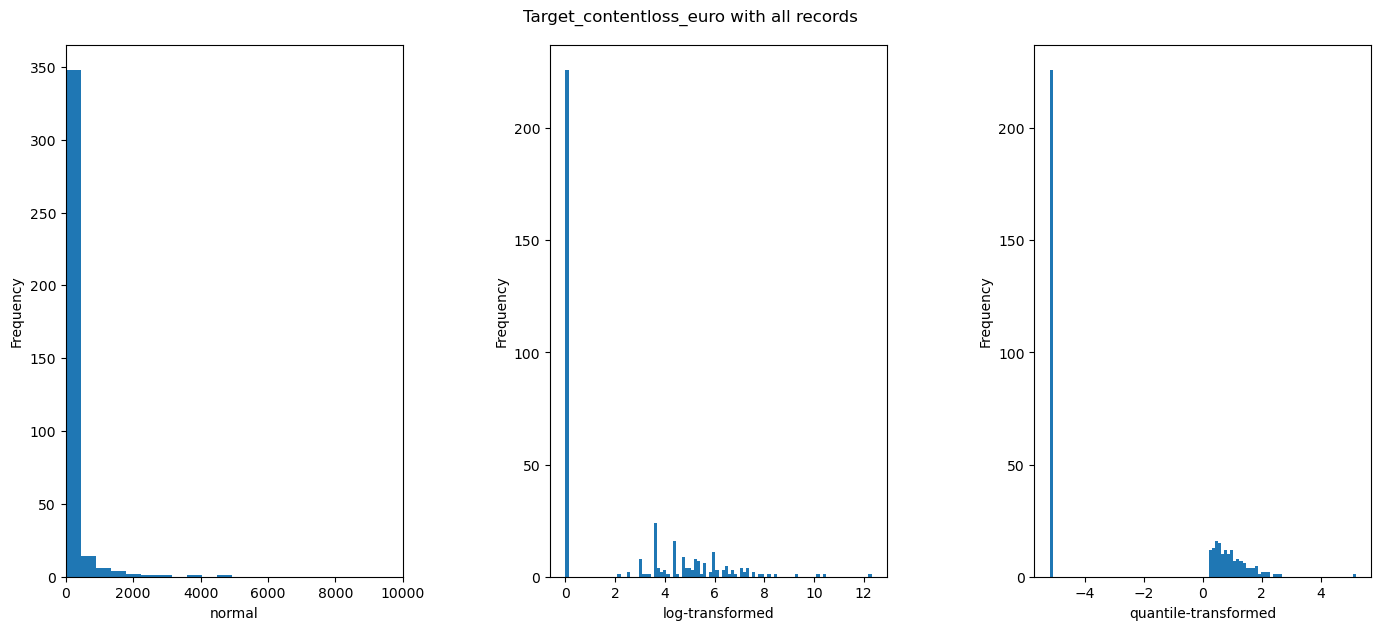

In [30]:
y = df_candidates.Target_contentloss_euro
y_log = np.log1p(y)
y_quantile = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True).squeeze()


#Below we plot the probability density functions of the target before and after applying the logarithmic functions.
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

ax0.hist(y, bins=500)
ax0.set_xlim([0, 10000])
ax0.set_ylabel("Frequency")
ax0.set_xlabel("normal")

ax1.hist(y_log, bins=100,)
ax1.set_ylabel("Frequency")
ax1.set_xlabel(f"log-transformed")


ax2.hist(y_quantile, bins=100,)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(f"quantile-transformed")

f.suptitle(f"{y.name} with all records", y=0.85)
plt.tight_layout(pad=5.0)


In [31]:
print(f"Removing {df_candidates.loc[df_candidates[target]==0,:].shape[0]} zero loss records")
df_candidates = df_candidates.loc[df_candidates[target]!=0,:]

print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

Removing 226 zero loss records
Keeping (171, 43) damage cases for model training and evaluation


### Plot tagret vs its log- and qunatile-transformed version

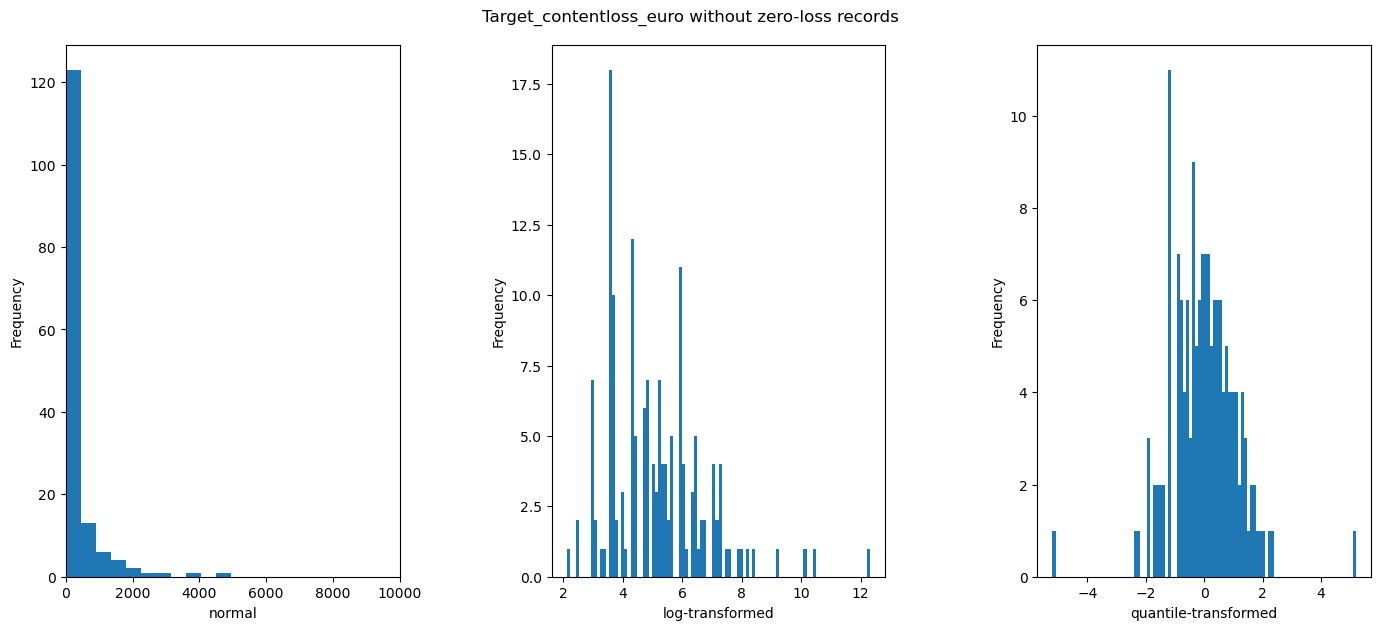

In [32]:
y = df_candidates.Target_contentloss_euro
y_log = np.log1p(y)
y_quantile = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True).squeeze()


#Below we plot the probability density functions of the target before and after applying the logarithmic functions.
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

ax0.hist(y, bins=500)
ax0.set_xlim([0, 10000])
ax0.set_ylabel("Frequency")
ax0.set_xlabel("normal")

ax1.hist(y_log, bins=100,)
ax1.set_ylabel("Frequency")
ax1.set_xlabel(f"log-transformed")


ax2.hist(y_quantile, bins=100,)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(f"quantile-transformed")

f.suptitle(f"{y.name} without zero-loss records", y=0.85)
plt.tight_layout(pad=5.0)


### Box-Cox transformation

Test Box-Cox transformation to find if the approach gives a good suggestion which transformation might be most useful to obtain a more normal distributed target. 

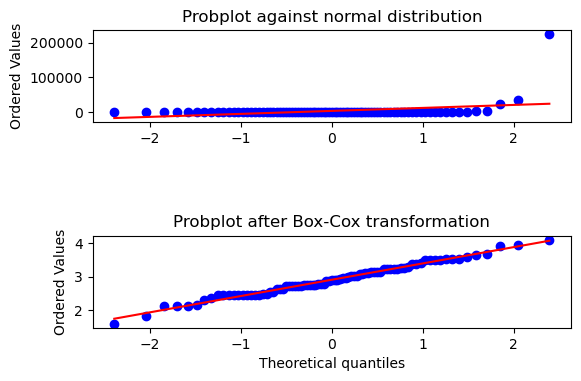

In [34]:
df_candidates = df_candidates.dropna()  # boxcox doesnt accept nan
y = df_candidates[target]

## apply box cox transfomration to get best normal distribution
try: 
    fitted_y, fitted_lambda = stats.boxcox(y)
except ValueError:
        fitted_y, fitted_lambda = stats.boxcox(y+1)

#df_candidates[target] = fitted_y


## plot new and old distribution
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_subplot(211)
prob = stats.probplot(y, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
prob = stats.probplot(fitted_y, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')


plt.tight_layout(pad=5.0)
plt.show()

best lambda: -0.22970312780440127


<Axes: ylabel='Density'>

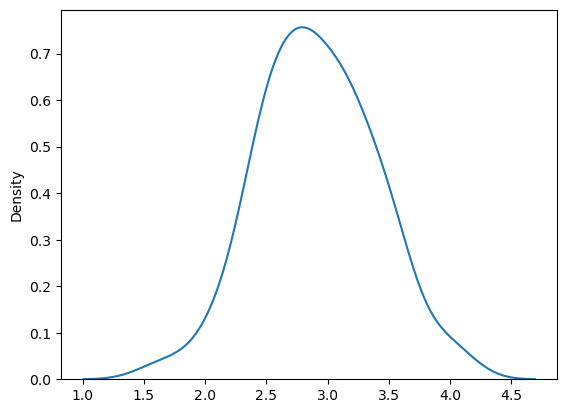

In [35]:
print("best lambda:", fitted_lambda)
# lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
# lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.

##  --> best transformation would be achieved with reciprocal transformation

import seaborn as sns
#sns.distplot(y, hist=False, kde=True) 
sns.distplot(fitted_y, hist=False, kde=True) 


In [36]:
df_candidates.shape

(83, 43)

### Test remove and merging further features

In [37]:
#df_candidates.info()

#df_candidates = df_candidates.dropna()

In [38]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
# d = scaler.fit_transform(X_unscaled)
# X_scaled = pd.DataFrame(d, columns=X_unscaled.columns)

# df_vif = pd.DataFrame()
# df_vif["X_features"] =  X_unscaled.columns

# ## fill possible important features with median, only for VIF calculation
# for f in ["shp_registered_capital_euro", "elevation_building_height_cm",  "shp_content_value_euro"]:
#     X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X_scaled[f"{f}"]))

# X_scaled_drop_nan = X_scaled.dropna()

# print(X_scaled.shape)
# print(X_scaled_drop_nan.shape)

# df_vif = fs.vif_score(X_scaled_drop_nan)
# print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
# # VIF >10 : high correlation with other features
# # VIF 1-5: medium correlation

### Test PCA or PLS on resilience and perception features

In [39]:
# df_candidates = df_candidates.drop([
#         "contaminations_light", "contaminations_heavy", "emergency_measures.9",
#         "emergency_measures.6", "emergency_measures.7", # BETTER DROP test rmv da nur binary
#         "elevation_rel2surrounding_cat",  # TEST
#         #"shp_profits_last5years", # TEST
#         "shp_monetary_resources4prevention", # TEST
#         'shp_finance_investments',
#         'shp_risk_tolerance',
#         'resilience_city_protection', 'resilience_left_alone',
#         'resilience_neighbor_management', 
#         # already in d_cleaning RM 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
#         'perception_who_responsible4protection.Rank1',
#         # ALREADY RM in d_cleaning: 'perception_private_economy_future' 
#         ], axis=1)


In [40]:
sys.path.insert(0, "../../../")
import utils.utils_figures as f

(83, 43)


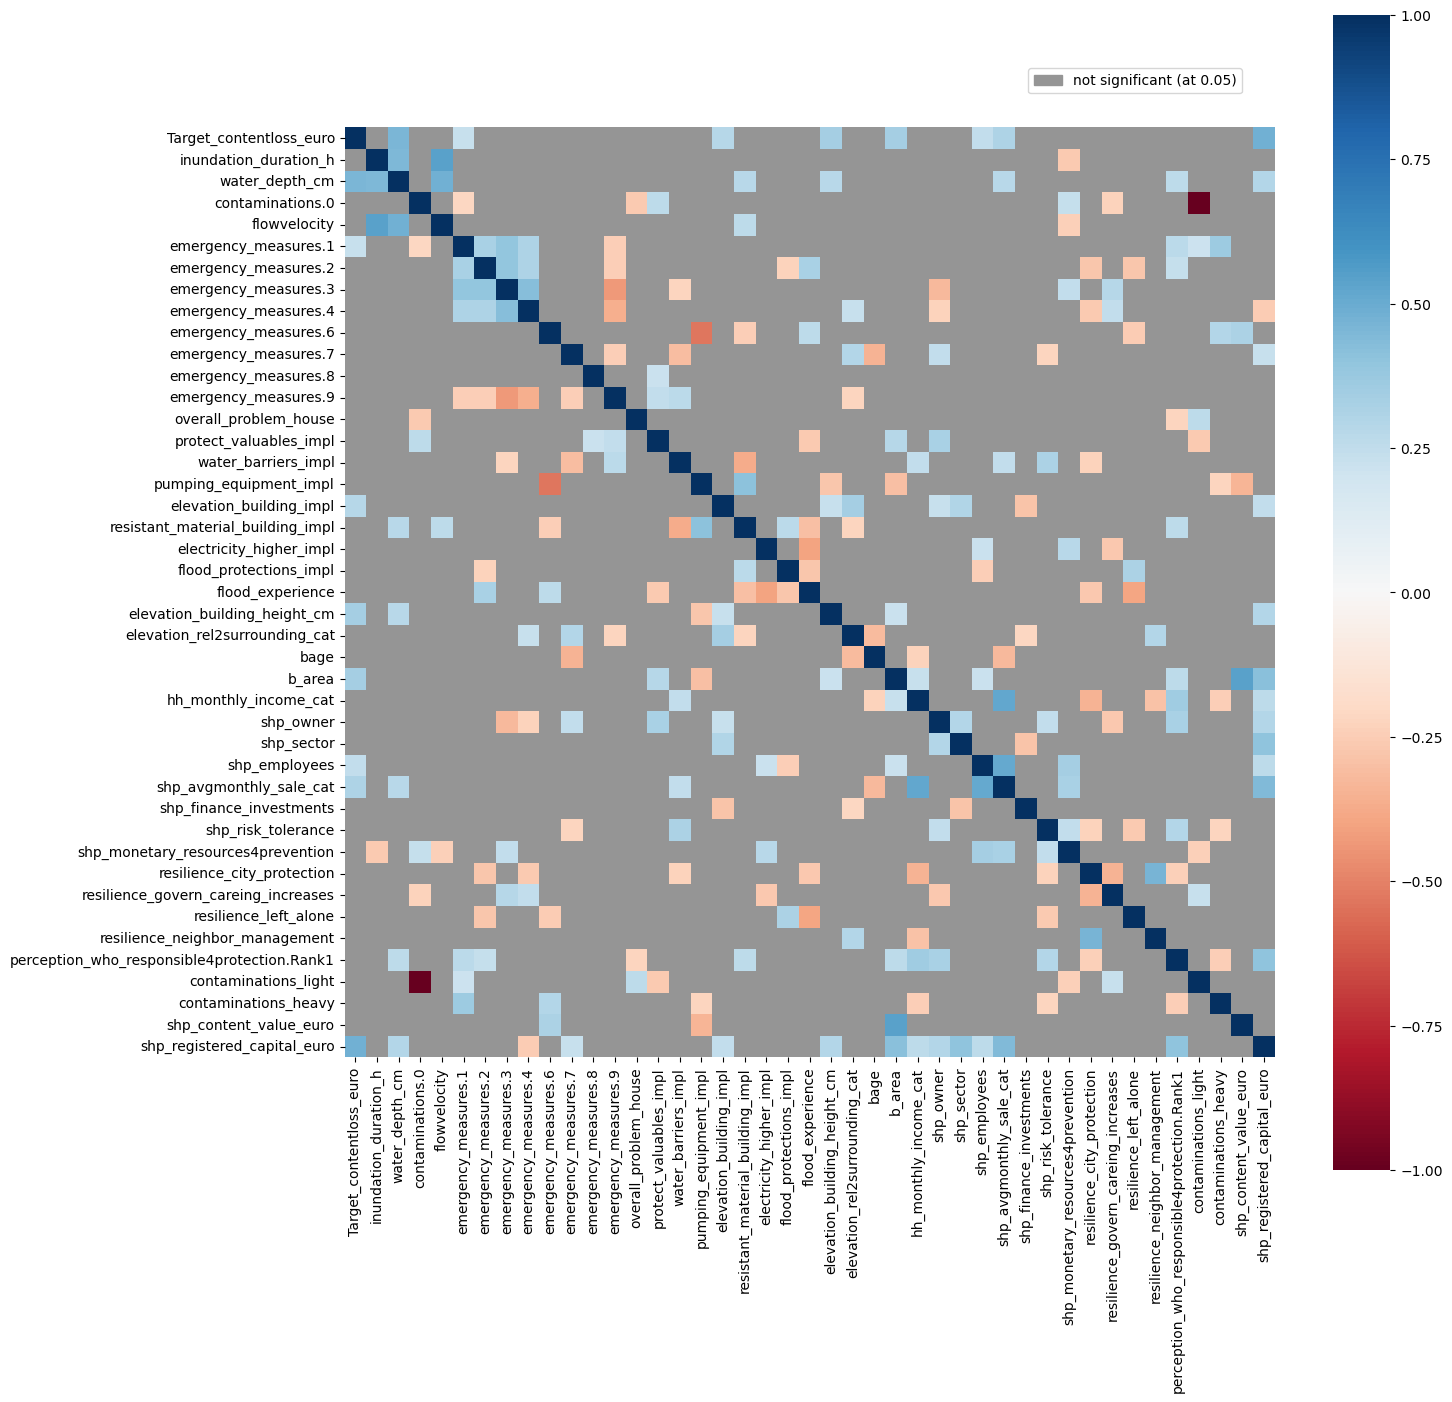

In [41]:
print(df_candidates.shape)

plt.figure(figsize=(15, 15))
f.plot_spearman_rank(df_candidates, min_periods=10, signif=True, psig=0.05)


## Fit model and select features

In [42]:
## Hyperparameter ranges to test

param_grid = {
    "model__alpha": [ 0.1, 1, 2, 3, 4, 5, 6],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "model__max_iter": [1,2,3,4,5, 8, 10],
    "model__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "model__tol": [0.5, 0.7, 1.0, 2.0 ,5.0, 10.0],
     "model__selection": ["cyclic", "random"],
    # "model__positive": [True],
    "model__random_state": [seed],
}


param_grid_transform = {
    "model__regressor__alpha": [ 0.1, 1, 2, 3, 4, 5, 6],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "model__regressor__max_iter": [1,2,3,4,5, 8, 10],
    "model__regressor__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "model__regressor__tol": [0.5, 0.7, 1.0, 2.0 ,5.0, 10.0],
    "model__regressor__selection": ["cyclic", "random"],
    "model__regressor__positive": [True],
    "model__regressor__random_state": [seed],
}

## paramter names when bootstrapping mehtod is applied
param_bag_grid = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_grid.items()}



param_bagging = {
    'bootstrap': [True, False],
    'random_state': [seed]
    # 'bootstrap_features': [True, False],
    # 'n_estimators': [20,50,100],
    # 'max_samples': [0.5,1.0, X_train.shape[0]//2,],
    # 'max_features': [0.5,1.0, X_train.shape[1]//2,],
    # oob_score
}
## TODO add hyperparams for Bagging: 
## current defaults: n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False


In [127]:
## iterate over both targets and store results 

eval_set_list = []

print(target)

## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
#pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#, "pipe_ximput_logr"]


for pipe_name in pipelines:

    print( f"\nApply Elastic Net on {target}, with pipeline {pipe_name}:")

    ## load sinlge pipeline
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
        

    df_candidates_t = df_candidates

    # # ##impute nans in X
    # for c in df_candidates_t.drop(target, axis=1): 
    #     #df_candidates_t[f"{c}"].fillna(value=np.nanmedian(df_candidates_t[f"{c}"]), inplace=True)
    #     df_candidates_t[c].fillna(df_candidates_t[c].median(), inplace=True)
 
     # print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
    #       { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

    ## clean df from all records containg nan
    df_candidates_t = df_candidates_t.dropna()
    ## clean df from nan in target
    df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]


    X_unscaled = df_candidates_t.drop(target, axis=1)  # remove  target from X
    y = df_candidates_t[target]
 
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X_unscaled, y, test_size=0.25, 
        random_state=seed, shuffle=True)
    
    ## save evaluation set for later usage in feature importance
    eval_set =  pd.concat([y_test, X_test], axis=1) #[(X_test, y_test)]
    eval_set_list.append({pipe_name : eval_set})

    ## normalize data 
    X_train, X_test = fs.normalize_X(X_train, X_test)
        
    print("Training size", X_train.shape)
    print("Test size", X_test.shape)
    
    # model = {'model': BaggingRegressor,   # default bootstrap=True
    #     'kwargs': {'estimator': ElasticNet()},  # TODO: pass 'random_state':seed to baggingregressor
    #     'parameters': param_grid,
    #     }
    ## Hyperparmaters and CV
    #cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)
    model_cv = RandomizedSearchCV(
        estimator= pipe,
        param_distributions=param_grid, #
        #param_distributions=param_bag_grid, 
        cv=cv, 
        scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
        refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
                        ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
                        ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
        random_state=seed
    )
    ## Fit model
    model_cv.fit(X_train, y_train)   
    model =  model_cv.best_estimator_

    if transformation:
        ## log transformed target
        model_log_pipe = Pipeline([
            ('model', TransformedTargetRegressor(regressor=ElasticNet(),
                func=np.log1p, inverse_func=np.expm1
            )
            )])  # np.expm1 = provides greater precision than exp(x) - 1 for small values of x.
        model_log_cv = RandomizedSearchCV(
            estimator= model_log_pipe,
            param_distributions=param_grid_transform,
            cv=cv, 
            scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,        
            random_state=seed
        )
        ## Fit model with log-transformed target
        model_log_cv.fit(X_train, y_train)   
        model_log = model_log_cv.best_estimator_


        ## quantile transformed target
        model_quantile_pipe = Pipeline([
            ('model', TransformedTargetRegressor(regressor=ElasticNet(),
                transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"))
            )])
        model_quantile_cv = RandomizedSearchCV(
            estimator= model_quantile_pipe,
            param_distributions=param_grid_transform, 
            cv=cv, 
            scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,        
            random_state=seed
        )
        ## Fit model with qunatile-transformed target
        model_quantile_cv.fit(X_train, y_train)   
        model_quantile = model_quantile_cv.best_estimator_


        model_reciprocal_pipe = Pipeline([
            ('model', TransformedTargetRegressor(regressor=ElasticNet(),
                transformer=PowerTransformer(method="box-cox", standardize=False) # def=True: 316, 248 MBE
                #func=np.reciprocal, inverse_func=np.expm1
            )
            )])  # np.expm1 = provides greater precision than exp(x) - 1 for small values of x.
        model_reciprocal_cv = RandomizedSearchCV(
            estimator= model_reciprocal_pipe,
            param_distributions=param_grid_transform,
            cv=cv, 
            scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,        
            random_state=seed
        )
        ## Fit model with reciprocal-transformed target
        model_reciprocal_cv.fit(X_train, y_train)   
        model_reciprocal = model_reciprocal_cv.best_estimator_


        model_sqrt_pipe = Pipeline([
            ('model', TransformedTargetRegressor(regressor=ElasticNet(),
                func=np.sqrt, inverse_func=np.square #np.expm1
            )
            )])  # np.expm1 = provides greater precision than exp(x) - 1 for small values of x.
        model_sqrt_cv = RandomizedSearchCV(
            estimator= model_sqrt_pipe,
            param_distributions=param_grid_transform,
            cv=cv, 
            scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,        
            random_state=seed
        )
        ## Fit model with reciprocal-transformed target
        model_sqrt_cv.fit(X_train, y_train)   
        model_sqrt = model_sqrt_cv.best_estimator_


    # ## store best trained model for evaluation
    # filename = f'./models_trained/elasticnet_{target}_{pipe_name}.sav'
    # pickle.dump(model, open(filename, 'wb'))

    # ## Feature importance + selection
    # importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

    # df_importance = pd.DataFrame(
    #     {"importances" : importances[0]},
    #     index=X_train.columns.to_list(),
    #     ) 
    # df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
    # print("Most important features:", df_importance.iloc[:5].index.to_list())
    # df_importance = df_importance.loc[df_importance.importances >= 0.000 , : ]
    # #df_importance.head(5)
    # # ## write selected predictors and response to disk
    # fs.save_selected_features(
    #     X_train, 
    #     pd.DataFrame(y_train, columns=[target]), 
    #     df_importance.T.columns, 
    #     filename=f"../../../input_survey_data/selected_predictors/fs_elasticnet_{target.split('_')[1]}_{pipe_name}.xlsx"
    # )

    ## Evaluate
    ## print evaluation report + check for overfitting 
    print("\nEvaluation without transformed target:")
    print("\nTraining set")
    y_pred_train = model.predict(X_train)
    e.evaluation_report(y_train, y_pred_train)

    print("\nTesting set")
    y_pred = model.predict(X_test)
    e.evaluation_report(y_test, y_pred)
    #print(e.compute_score(y_test, y_pred))

    if transformation:
        for model in [{model_log:"natural log"}, {model_quantile: "quantile"}, {model_reciprocal:"box-cox decided"}, {model_sqrt:"sqrt"}]:
            transf_type = list(model.values())[0]
            model = list(model.keys()) [0]
            #transf_type = str(model).split("transformer=")[1].split("Transformer")[0]
            print(f"\nEvaluation with {transf_type}-transfomred target:")
            print("\nTraining set")
            y_pred_train = model.predict(X_train)
            e.evaluation_report(y_train, y_pred_train)

            print("\nTesting set")
            y_pred = model.predict(X_test)
            e.evaluation_report(y_test, y_pred)
            #print(e.compute_score(y_test, y_pred))


Target_contentloss_euro

Apply Elastic Net on Target_contentloss_euro, with pipeline pipe_en:
Training size (62, 42)
Test size (21, 42)

Evaluation without transformed target:

Training set
Model Performance:
        Root Mean Square Error: 25226.59
        Normalized Root Mean Square Error: 6.38
        Mean Absolute Error: 7758.37
        Mean Bias Error: -0.0
        R²-Score: 0.22
    

Testing set
Model Performance:
        Root Mean Square Error: 5348.21
        Normalized Root Mean Square Error: 1.57
        Mean Absolute Error: 4280.03
        Mean Bias Error: -4280.03
        R²-Score: -48.554
    

Evaluation with natural log-transfomred target:

Training set
Model Performance:
        Root Mean Square Error: 28202.74
        Normalized Root Mean Square Error: 37.58
        Mean Absolute Error: 4681.5
        Mean Bias Error: 4596.56
        R²-Score: 0.025
    

Testing set
Model Performance:
        Root Mean Square Error: 737.66
        Normalized Root Mean Square Error: 7

### Duan's smearing, 
non-parametric approach via residuals


In [152]:
# ttr = TransformedTargetRegressor(    ## TODO replace ttr by model_log_cv
#     regressor=ElasticNet(),
#     func=np.log1p, inverse_func=np.expm1
#     )

# f = ttr.get_params()['func']              #function
# inv_f = ttr.get_params()['inverse_func']  #and inverse function

In [147]:
print(stats.describe(y_test), "\n")
print(stats.describe(model.predict(X_test)))
print(stats.describe(model_log.predict(X_test)))
print(stats.describe(model_quantile.predict(X_test)))

# kurtosis= peak from gaussian distrib, Negative kurtosis means that the data has fewer extreme outliers than a normal distribution.


DescribeResult(nobs=21, minmax=(11.0, 3624.4), mean=373.44761904761907, variance=606075.2596190477, skewness=3.702090257677358, kurtosis=12.987217450109926) 

DescribeResult(nobs=21, minmax=(275.36586130468714, 1739.8196599042924), mean=657.9728225853712, variance=180670.61550377856, skewness=1.1587763985268558, kurtosis=0.1755108157907368)
DescribeResult(nobs=21, minmax=(74.48015097911612, 446.55676677543664), mean=181.04365890366606, variance=10959.098120185936, skewness=1.733471438117324, kurtosis=1.8685600769399482)
DescribeResult(nobs=21, minmax=(74.7, 368.3), mean=123.28677018538568, variance=6338.7738006380105, skewness=2.0879279329161617, kurtosis=3.404912238580299)


In [161]:
# pred_log = model_log.predict(X_test)
# resids = y_test - pred_log
# resids = resids.values.reshape(1, X_test.shape[0])
# resids
# dp = inv_f(pred_log.reshape( X_test.shape[0], 1) + resids)
# pred_log_dp = dp.mean(axis=1)
# pred_log_dp

# # dat[['y','WrongTrans','DuanPreds']].describe()
# # log_pred = f(dat['WrongTrans'])
# # resids = f(dat['y']) - log_pred
# # resids = resids.values.reshape(1,n[0])
# # dp = inv_f(log_pred.values.reshape(n[0],1) + resids)
# # dat['DuanPreds'] = dp.mean(axis=1)

# # dat[['y','WrongTrans','DuanPreds']].describe()


In [138]:
model_reciprocal.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('model',
                 TransformedTargetRegressor(regressor=ElasticNet(alpha=1,
                                                                 l1_ratio=0.0,
                                                                 max_iter=4,
                                                                 positive=True,
                                                                 random_state=42,
                                                                 selection='random',
                                                                 tol=5.0),
                                            transformer=PowerTransformer(method='box-cox',
                                                                         standardize=False)))])>

In [46]:
model_cv.best_params_


{'model__tol': 0.5,
 'model__selection': 'random',
 'model__random_state': 42,
 'model__max_iter': 5,
 'model__l1_ratio': 0.5,
 'model__alpha': 3}

In [47]:
## An MAE(-of-the-logs) of 0.01 would tell you that typically your original values deviate by about 1% from the geometric mean.

In [48]:
print(stats.describe(y_test), "\n")
print(stats.describe(model.predict(X_test)))
print(stats.describe(model_log.predict(X_test)))
print(stats.describe(model_quantile.predict(X_test)))

# kurtosis= peak from gaussian distrib, Negative kurtosis means that the data has fewer extreme outliers than a normal distribution.


DescribeResult(nobs=21, minmax=(11.0, 3624.4), mean=373.44761904761907, variance=606075.2596190477, skewness=3.702090257677358, kurtosis=12.987217450109926) 

DescribeResult(nobs=21, minmax=(272.05153211269317, 13010.983738324969), mean=4653.477923242152, variance=12117213.438598245, skewness=0.8593153437165512, kurtosis=-0.020965439133620922)
DescribeResult(nobs=21, minmax=(74.48015097911612, 446.55676677543664), mean=181.04365890366606, variance=10959.098120185936, skewness=1.733471438117324, kurtosis=1.8685600769399482)
DescribeResult(nobs=21, minmax=(74.7, 368.3), mean=123.28677018538568, variance=6338.7738006380105, skewness=2.0879279329161617, kurtosis=3.404912238580299)


163    inf
7      inf
129    inf
164    inf
113    inf
152    inf
62     inf
266    inf
22     inf
68     inf
244    inf
175    inf
340    inf
183    inf
341    inf
209    inf
364    inf
327    inf
280    inf
195    inf
53     inf
Name: Target_contentloss_euro, dtype: float64


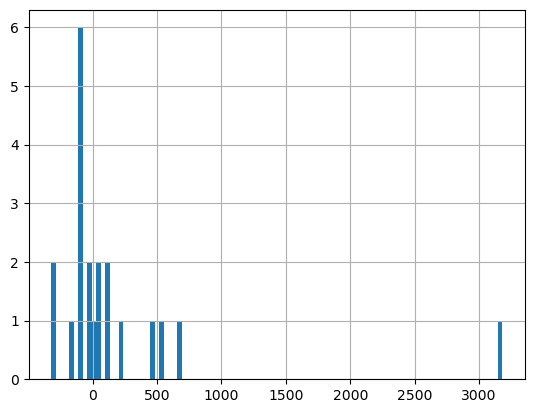

In [ ]:

resids = y_test  - model_log.predict(X_test)

# Check to make sure that the residuals are really close to normal.Before doing this
resids.hist(bins=100)

# Approach for just log transformed
mult = np.exp(0.5*resids.var())
print( np.exp(y_test)*mult )
##########

In [ ]:
from sklearn.linear_model import ElasticNetCV

tst_cv_with_trans_target = TransformedTargetRegressor(
    regressor=ElasticNetCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_log = tst_cv_with_trans_target.predict(X_test)

e.evaluation_report(y_test, y_pred_log)

print(e.compute_score(y_test, y_pred_log))
#?zip
#pd.DataFrame(zip(y_test.to_list(), y_pred_log))

Model Performance:
        Root Mean Square Error: 799.16
        Normalized Root Mean Square Error: 2.86
        Mean Absolute Error: 386.56
        Mean Bias Error: 159.47
        R²-Score: -0.106
    


AttributeError: module 'utils.utils_evaluation' has no attribute 'compute_score'

In [ ]:
print(y_test.to_list())
print(y_pred)


[73.7, 29.5, 153.1, 84.3, 224.2, 37.4, 18.7, 39.7, 268.1, 73.7, 110.5, 11.0, 165.6]
[155.41302082 149.5         82.8        141.74123768 125.32141596
 149.5         76.93773359 119.         139.11727656  76.5
 115.75648501  76.5        119.        ]


In [ ]:
# fi_cols =  df_importance.loc[df_importance.importances >= 0.0001 , : ].index.to_list()#.shape

# model = model_cv.best_estimator_
# model.fit(X_train.loc[:, fi_cols], y_train)

# print(len(fi_cols))

In [ ]:
# y_pred_train_fi = model.predict(X_train.loc[:, fi_cols])
# e.evaluation_report(y_train, y_pred_train_fi)

# y_pred_fi = model.predict(X_test.loc[:, fi_cols])
# e.evaluation_report(y_test, y_pred_fi)


In [ ]:
## reload models


#pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()


In [ ]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

R^2 training set 19.66  %
R^2 test set -368139.24


In [ ]:
print("if alpha < 0.5 used more Ridge regularization: \n" , model.get_params())

if alpha < 0.5 used more Ridge regularization: 
 {'memory': None, 'steps': [('model', ElasticNet(alpha=3, max_iter=5, random_state=42, selection='random', tol=0.5))], 'verbose': False, 'model': ElasticNet(alpha=3, max_iter=5, random_state=42, selection='random', tol=0.5), 'model__alpha': 3, 'model__copy_X': True, 'model__fit_intercept': True, 'model__l1_ratio': 0.5, 'model__max_iter': 5, 'model__positive': False, 'model__precompute': False, 'model__random_state': 42, 'model__selection': 'random', 'model__tol': 0.5, 'model__warm_start': False}


## Evaluation

### Plot prediction error 

In [ ]:
#y_pred_log_train = model_log.predict(X_train)
y_pred = model.predict(X_test)
y_pred_log = model_log.predict(X_test)
y_pred_quantile = model_quantile.predict(X_test)


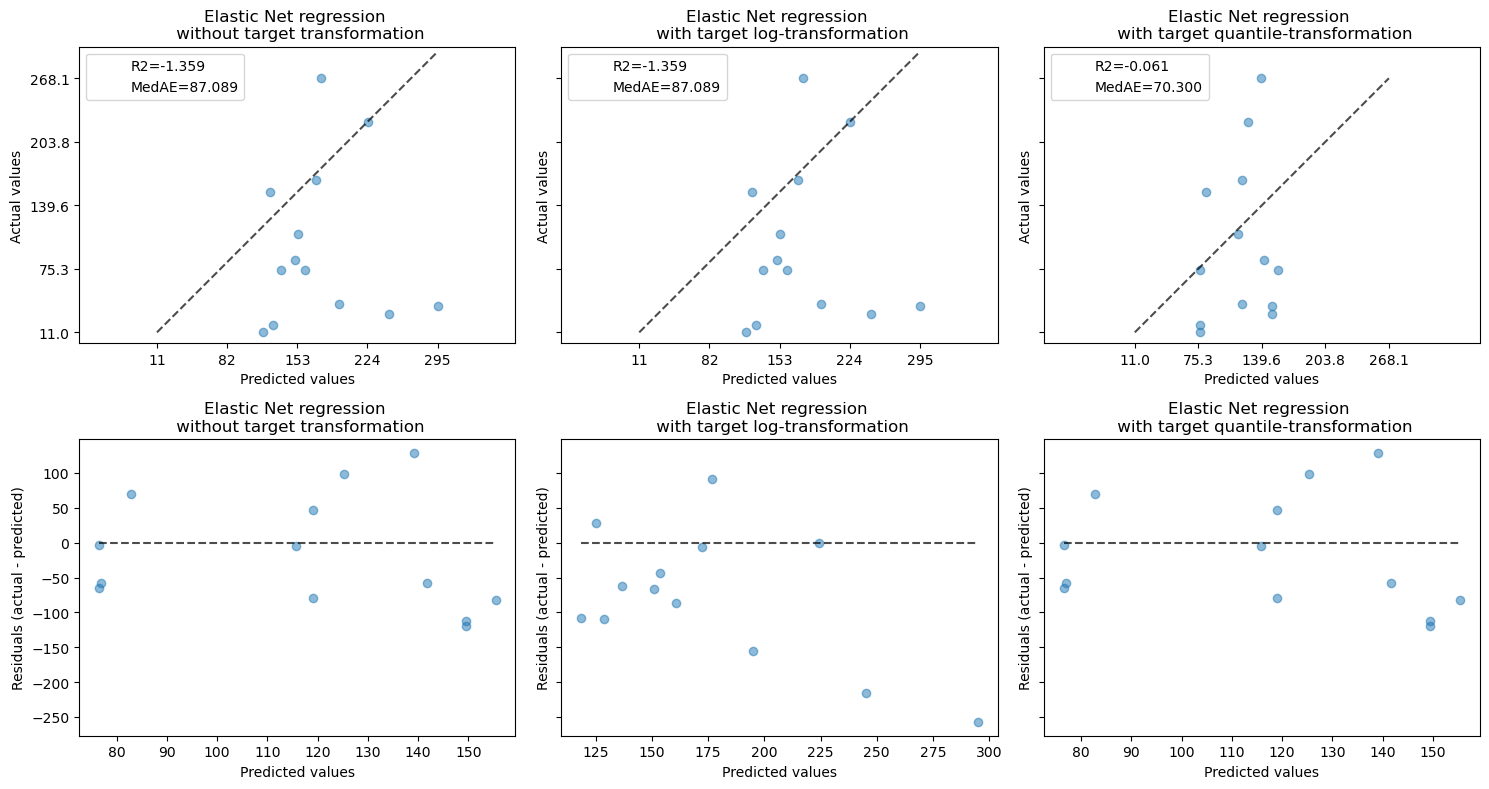

In [474]:
f, (ax0, ax1) = plt.subplots( 2, 3,  sharey="row", figsize=(15, 8)) # 


PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="actual_vs_predicted",
    ax=ax0[2],
    scatter_kwargs={"alpha": 0.5},
)
ax0[0].set_title("Elastic Net regression \n without target transformation")
ax0[1].set_title("Elastic Net regression \n with target log-transformation")
ax0[2].set_title("Elastic Net regression \n with target quantile-transformation")

ax0[0].set_ylim(0, 300)


# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1], ax0[2]], [y_pred, y_pred_log, y_pred_quantile]):
    for name, score in e.compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="residual_vs_predicted",
    ax=ax1[2],
    scatter_kwargs={"alpha": 0.5},
)

ax1[0].set_title("Elastic Net regression \n without target transformation")
ax1[1].set_title("Elastic Net regression \n with target log-transformation")
ax1[2].set_title("Elastic Net regression \n with target quantile-transformation")

#ax1[0].set_ylim(0,200)


#f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

In [473]:
residuals = y_test - y_pred
residuals

163    -87.08860
7     -215.91465
129     28.07582
164    -66.50318
113     -0.22487
152   -257.59507
62    -110.18732
266   -155.07931
22      91.44927
68     -62.79247
244    -43.09106
175   -107.59088
340     -6.49362
Name: Target_contentloss_euro, dtype: float64

In [368]:
# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model_cv.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_bagging__estimator__alpha",
#             "param_bagging__estimator__l1_ratio",
#             "param_bagging__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


In [378]:
X_unscaled.shape


(180, 34)

### Feature importance 

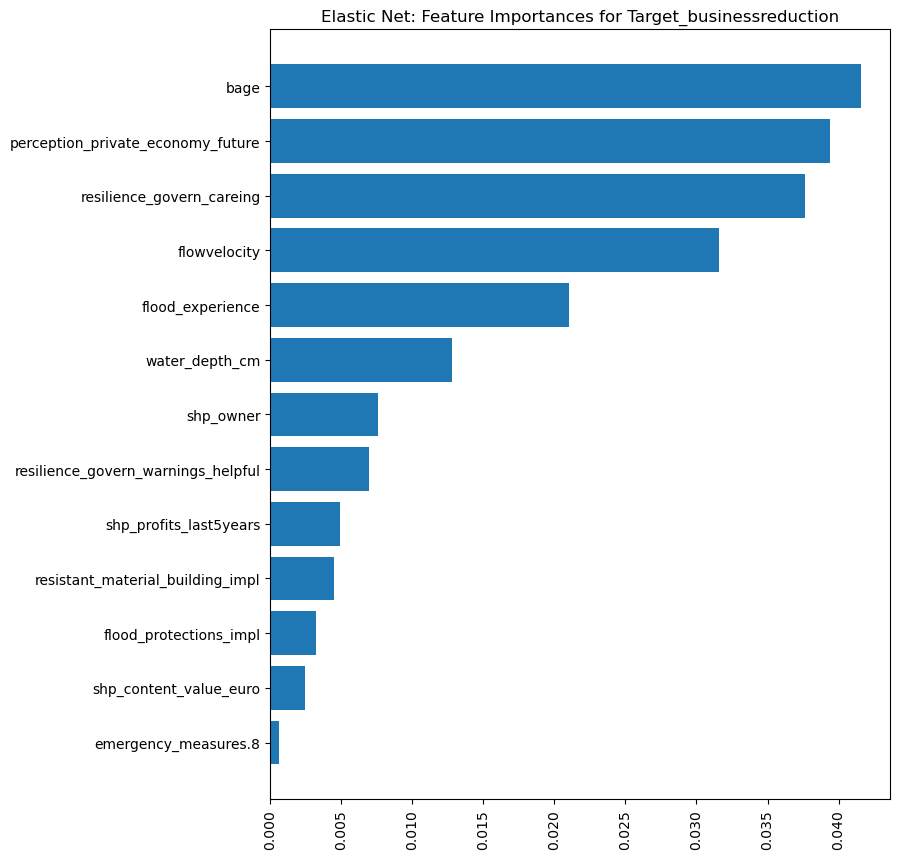

In [379]:
# plot feature importance
#fig, ax = plt.subplots(figsize=(12,5))

# relaod evalation set
eval_set = eval_set_list[0][pipe_name]

importances = e.permutation_feature_importance(model, 
                                               X_test,
                                               y_test,
                                               #eval_set.drop(target, axis=1), 
                                               #eval_set[target], 
                                               repeats=5, seed=seed
                                               )

## feature importance scores
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : importances[0],
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
df_importance = df_importance.sort_values("importances", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Elastic Net: Feature Importances for {target}")
plt.show()

## save importnace scores  and figure
filepath = f'./models_evaluation/best_elasticnet_importance_scores_{target}_{pipe_name}'
if not glob(filepath):
    df_importance.to_csv(filename, index = False)


#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')

In [ ]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

In [ ]:
importances_cv = e.permutation_feature_importance(model_cv.best_estimator_, X_test, y_test, repeats=5, seed=seed)
importances_cv

df_importance = pd.DataFrame(
    {"importances" : importances_cv[0]},
    index=X_train.columns.to_list(),
    ) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
print("Most important features:", df_importance.iloc[:5].index.to_list())
df_importance = df_importance.loc[df_importance.importances >= 0.0001, : ]

df_importance

Most important features: ['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience']


,importances
bage,0.041559
perception_private_economy_future,0.039380
resilience_govern_careing,0.037630
flowvelocity,0.031579
flood_experience,0.021052
water_depth_cm,0.012803
shp_owner,0.007570
resilience_govern_warnings_helpful,0.006977
shp_profits_last5years,0.004885
resistant_material_building_impl,0.004471


In [ ]:
# fi_cols =  df_importance.loc[df_importance.importances >= 0.0001 , : ].index.to_list()#.shape


# model_cv = RandomizedSearchCV(
#     estimator=pipe, 
#     param_distributions=param_grid, #
#     #param_distributions=param_bag_grid, 
#     cv=cv, 
#     scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
#     refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
#                     ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
#                     ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
#     random_state=seed
# )
# ## Fit model
# model_cv.fit(X_train.loc[:, fi_cols], y_train)   

# print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train.loc[:, fi_cols], y_train))
# print('Test R^2 Score : %.3f'%model_cv.best_estimator_.score(X_test.loc[:, fi_cols], y_test))
# #print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))


# ## fit model again with best hyperparams
# print("Create new Elastic Net model based on best hyperparameters")
# model =  model_cv.best_estimator_


In [ ]:
model_cv.best_params_

## basis: bred, test set /Train 26R2)
#    Model Performance:
#         Mean Squared Error: 856.8
#         Root Mean Square Error: 29.3
#         Mean Absolute Error: 22.7
#         Mean Absolute Percentage Error: inf
#         R²-Score: -0.16
#         Adjusted R²-Score: 2.32

{'model__tol': 0.5,
 'model__selection': 'random',
 'model__max_iter': 10,
 'model__l1_ratio': 0.75,
 'model__alpha': 0.1}

In [ ]:
importances_cv = e.permutation_feature_importance(model_cv.best_estimator_, X_test, y_test, repeats=5, seed=seed)
importances_cv

df_importance = pd.DataFrame(
    {"importances" : importances_cv[0]},
    index=X_train.columns.to_list(),
    ) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
print("Most important features:", df_importance.iloc[:5].index.to_list())
df_importance = df_importance.loc[df_importance.importances >= 0.0001, : ]

df_importance

Most important features: ['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience']


,importances
bage,0.041559
perception_private_economy_future,0.039380
resilience_govern_careing,0.037630
flowvelocity,0.031579
flood_experience,0.021052
water_depth_cm,0.012803
shp_owner,0.007570
resilience_govern_warnings_helpful,0.006977
shp_profits_last5years,0.004885
resistant_material_building_impl,0.004471


#### Save best model, its hyperparamters, and evaluation scores and selected features

In [ ]:
## Stored best xgb model for business reduction: best_xgboost_Target_businessreduction_pipe_xgb.sav
## Its hyperaprams xgb_best_param_model_cv.best_params_  # early_stop=3

## best model and hyperparams (here early stoping =3)
filename = f'./models_trained/best_elasticnet_{target}_{pipe_name}.sav'
if not glob(filename):
    pickle.dump(model, open(filename, 'wb'))

best_params = model_cv.best_params_
best_params = pd.DataFrame({"hyperparameter":best_params.keys(), "value":best_params.values()})
filepath = f'./models_evaluation/best_elasticnet_hyperparams_{target}_{pipe_name}.sav'
if not glob(filepath):
    best_params.to_csv(filename, index = False)

# ## eval report
# y_pred_train = model.predict(X_train)
# e.evaluation_report(y_train, y_pred_train,
#                     filepath=f"./models_evaluation/elasticnet/best_eval_train_{target.split('_')[1]}_{pipe_name}.csv")
# y_pred = model.predict(X_test)
# e.evaluation_report(y_test, y_pred, 
#                     filepath=f"./models_evaluation/elasticnet/best_eval_test_{target.split('_')[1]}_{pipe_name}.csv")

# ## selected features
# fs.save_selected_features(
#         X_train, 
#         pd.DataFrame(y_train, columns=[target]), 
#         df_importance.T.columns, 
#         filename=f"../../../input_survey_data/selected_predictors/best_fs_elasticnet_{target.split('_')[1]}_{pipe_name}.xlsx"
#     )

### Plot optimal number of features

In [22]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head(2)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bagging__estimator__tol', 'param_bagging__estimator__selection',
       'param_bagging__estimator__random_state',
       'param_bagging__estimator__positive',
       'param_bagging__estimator__max_iter',
       'param_bagging__estimator__l1_ratio', 'param_bagging__estimator__alpha',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'split12_test_score', 'split13_test_score', 'split14_test_score',
       'split15_test_score', 'split16_test_score', 'split17_test_score',
       'split18_test_score', 'split19_test_score', 'split20_test_score',
       'split21_test_score', 'split22_test_score', 'split23_test_score',
       'split24_test_score', 'split25_tes

In [25]:
#cv_results["params"][0]

In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')